<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/deep_learning/final_3043532a_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playing the Stock Market is a Fools Game!


**The training data provided gives the daily percentage movement of stock prices for 442 companies from 05/04/2010 to 31/03/2022. Task is to predict the daily percent movement of the 442 companies on the 1st of April 2022**

In [1]:
!pip3 install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 13.8 MB/s eta 0:00:00


In [2]:
!pip3 install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [26]:
%matplotlib inline

# Common imports
import os
from dateutil.parser import parse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from captum.attr import IntegratedGradients

use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Load the dataset - train and submission

**Drop ID column and transpose for time series format:** Removes the 'ID' column from the train DataFrame and transposes it.

**Rename columns:**Assigns new column names to the transposed DataFrame, labeling them as company_0, company_1, ..., up to company_441

**Extract and convert index to datetime:** Converts the index values to datetime objects, assuming a day-first format (e.g., DD/MM/YYYY).
Sets the converted datetime values as the new index of the DataFrame.

**Normalize data:**Initializes a StandardScaler object to standardize the data.
Fits the scaler to the data and transforms it, normalizing the values.

In [27]:
# Load Data - train and submission files
train = pd.read_csv("./train.csv")
submission = pd.read_csv("./sample_submission.csv")

# Drop ID column and transpose for time series format
train_data = train.drop(columns=['ID']).T
train_data.columns = [f"company_{i}" for i in range(442)]
dates = train_data.index
dates = pd.to_datetime(train_data.index, dayfirst=True)
train_data.index = dates

# Convert to numpy array
data = train_data.values.astype(float)

# Normalize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# train.head()
train_data.tail()

,company_0,company_1,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,...,company_432,company_433,company_434,company_435,company_436,company_437,company_438,company_439,company_440,company_441
2022-03-25,0.86,0.93,0.10,2.02,-1.53,2.08,1.54,0.17,1.96,-0.05,...,0.66,-1.40,2.20,0.26,0.49,0.18,-0.25,1.93,0.37,0.94
2022-03-28,0.31,1.55,0.90,2.74,-0.64,-0.13,-3.39,-0.21,-2.97,-0.42,...,0.23,1.97,0.18,0.56,-0.24,-0.05,0.45,-0.50,1.18,0.65
2022-03-29,0.95,3.96,3.05,2.33,2.32,4.38,0.10,1.72,-1.16,2.91,...,2.51,2.72,-0.59,-0.30,1.88,3.77,2.04,2.67,3.02,2.36
2022-03-30,0.68,0.41,-1.24,0.80,-1.64,-2.53,0.08,-1.17,1.96,0.57,...,-1.35,-2.95,0.84,-1.61,-1.58,-1.16,-3.71,-2.61,0.53,0.91
2022-03-31,-0.52,1.08,-1.26,-0.91,-4.58,-5.44,-2.42,-1.24,-1.55,-1.78,...,-2.35,-1.23,-2.79,-3.63,-1.90,-1.85,-2.04,-3.83,-1.73,-0.49


# Train - Validation split

A function create_sequences takes normalized data and generates input-output pairs for a sequence prediction task. It uses a sliding window approach with a sequence length of 30
The resulting sequences are split into training and validation sets, with 80% used for training and the last 20% for validation.

In [28]:
# Create Sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Better Train-Validation Split (80-20 split)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"Number of training sequences: {len(X_train)}, Validation sequences: {len(X_val)}")

Number of training sequences: 2392, Validation sequences: 599


**DataLoader**

A batch size of 64 is defined, meaning data will be processed in groups of 64 sequences at a time.
train_loader is created using DataLoader, which wraps the training data (X_train, y_train) into a TensorDataset. It enables batching with the specified size and shuffles the data to improve training robustness.

In [29]:
# Create DataLoader
batch_size = 64

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

# Define LTSM Model

This code defines a LSTMModel for time series prediction using a bidirectional LSTM with layer normalization.

*   It takes an input dimension, hidden dimension , number of LSTM layers, output dimension, and a dropout rate as parameters.
*   The LSTM is bidirectional (processes sequences in both directions), with dropout applied between layers if there’s more than one layer, and it outputs a hidden state doubled in size due to bidirectionality.
*   Layer normalization is applied to stabilize and normalize the outputs of the LSTM’s last time step.
*   Dropout is used for regularization to prevent overfitting, followed by a linear layer to produce the final output.

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return out

# Optuna Hyperparameter Optimization


# Hyperparameter Optimization with Optuna


This code defines an objective function for hyperparameter tuning of an LSTM model using Optuna. It suggests values for hidden_dim, num_layers, learning rate, and dropout. The model, with 442 input and output dimensions, is trained  using Adam optimizer and mean squared error (MSE) loss. For each epoch, the model processes training batches, computes loss, and updates weights, then evaluates validation loss without gradients. The best validation loss is returned.

The Optuna study minimizes this loss over 20 trials, testing different parameter combinations. Finally, it prints the best parameters and MSE achieved. This process optimizes the LSTM model for tasks like time series prediction by finding the most effective settings.

In [6]:
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    model = LSTMModel(input_dim=442, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=442).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    return val_loss / len(val_loader)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_params

[I 2025-03-27 10:48:19,544] A new study created in memory with name: no-name-a46c003c-bf5d-4b86-be71-ca2c63d0f1e0
<ipython-input-6-654b1a422307>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-03-27 10:51:07,254] Trial 0 finished with value: 1.5145785808563232 and parameters: {'hidden_dim': 94, 'num_layers': 3, 'lr': 0.003225161455091114}. Best is trial 0 with value: 1.5145785808563232.
<ipython-input-6-654b1a422307>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-03-27 10:53:10,613] Trial 1 finished with value: 1.4512451887130737 and parameters: {'hidden_di

# Train Model with best hyperparameters:

This code uses the best hyperparameters (best_params) from the previous Optuna study to train an LSTM model. The model is initialized with an input and output dimension of 442, and the tuned values for hidden_dim, num_layers, and dropout. It uses mean squared error (MSE) as the loss function and the Adam optimizer with the optimized learning rate (lr).

Training runs for 200 epochs. In each epoch, the model processes batches from train_loader, computes predictions, calculates loss, and updates weights via backpropagation.

In [7]:
model = LSTMModel(input_dim=442, hidden_dim=best_params['hidden_dim'], num_layers=best_params['num_layers'], output_dim=442).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

# Prediction for 1st April, 2022

This code generates a prediction using the trained LSTM model. The model is set to evaluation mode and with gradients disabled it predicts the next value. Finally, converts it back to the original scale, yielding the final prediction for interpretation.

In [8]:
X_input = torch.tensor(data_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(X_input).cpu().numpy()

Saving the submission after adjusting proper dimensions

In [9]:
print("Prediction shape:", pred.shape)
print("Submission target shape:", submission.iloc[:, 1:].shape)

# Ensure pred is reshaped correctly
pred = pred.reshape(-1, 1)  # Convert (1, 442) to (442, 1)

# Assign correctly
submission.iloc[:, 1:] = pred
submission.to_csv("submission.csv", index=False)

print("Submission file saved successfully!")

Prediction shape: (1, 442)
Submission target shape: (442, 1)
Submission file saved successfully!


<ipython-input-9-561b7ccbf755>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.17740886  0.54315674  0.69541866  0.42476293  0.67698556  0.7454426
  0.13431975  0.57044405  0.19831195  0.48685554  0.3336899   0.36100608
  0.5548999   0.66768134  0.2929164   0.23515402  0.6731502  -0.09453578
  0.33705357  0.78241885  0.5723196   0.5696969   0.40109915  0.15601218
 -0.10770342 -0.00641166  0.5727445   0.22129238  0.45549196  0.48480427
 -0.08892862  0.5121425   0.00390061  0.5407455   0.20732374  0.67667913
  0.33515343  0.64984894  0.2902111   0.34060675  0.48838913  0.22466162
  0.3479178   0.624671   -0.23645584  0.56212634  0.6521686   0.39507383
  0.54856336  0.5449576   0.30611104  0.72087127  0.39939508  0.32000813
  0.17721891  0.43112135  0.42994034  0.61434734  0.7450402   0.51459306
  0.5605526   0.36818483  0.41870123  0.74843454  0.6770925   0.35347492
  0.43535233  0.20783803  0.5607944  -0.160212

# Model Interpretation with Captum

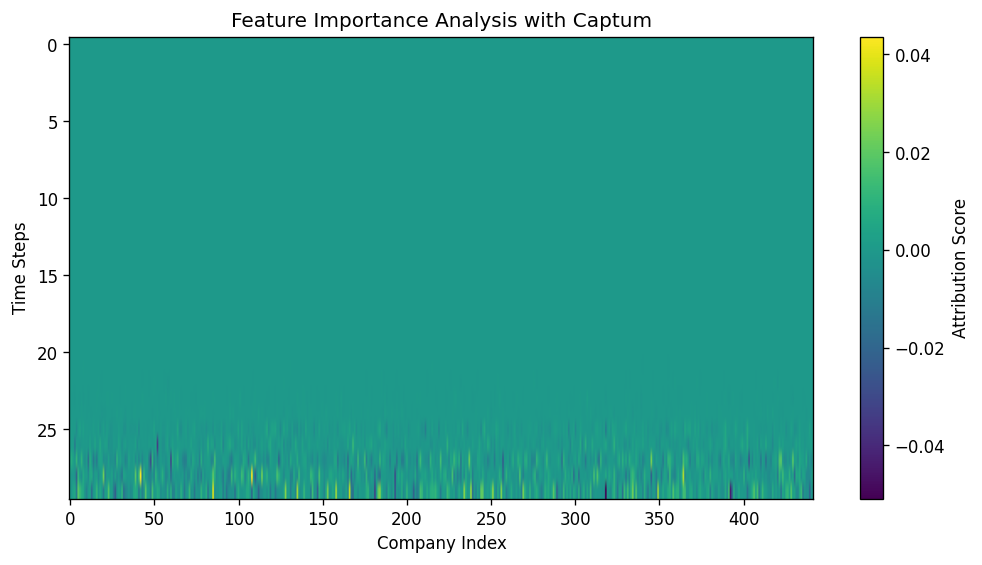

In [10]:
# Captum for model interpretation
ig = IntegratedGradients(model)
X_input.requires_grad_()
attr = ig.attribute(X_input, target=0)
attr = attr.squeeze().detach().cpu().numpy()

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.imshow(attr, cmap="viridis", aspect="auto")
plt.colorbar(label="Attribution Score")
plt.title("Feature Importance Analysis with Captum")
plt.xlabel("Company Index")
plt.ylabel("Time Steps")
plt.show()

In [21]:
from captum.attr import IntegratedGradients, FeatureAblation
from optuna.importance import get_param_importances

# Optuna - Hyperparameter Importance Analysis
param_importances = get_param_importances(study)
print("Hyperparameter Importance Ranking:")
for param, importance in param_importances.items():
    print(f"{param}: {importance:.4f}")

Hyperparameter Importance Ranking:
lr: 0.6842
hidden_dim: 0.2659
num_layers: 0.0499


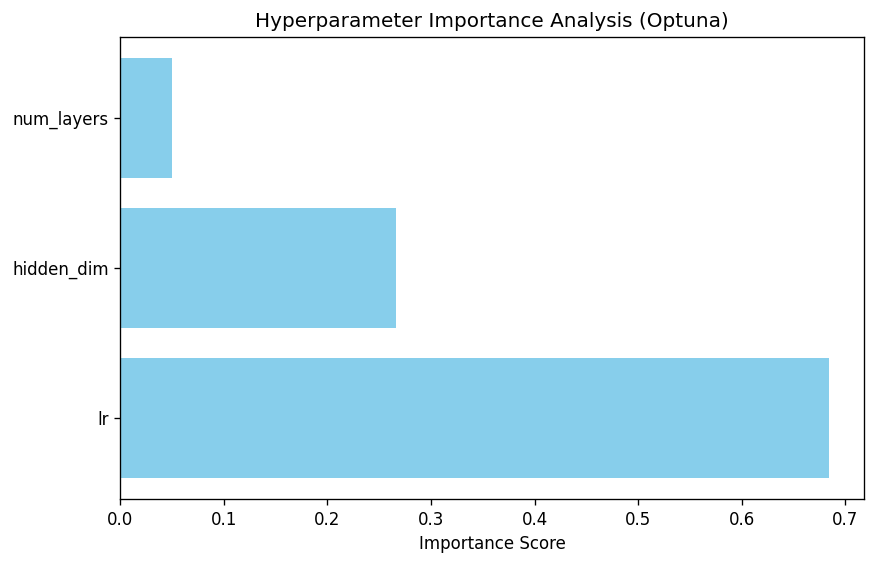

In [22]:
# Captum - Feature Importance Analysis
# Run Integrated Gradients on an example input (last sequence)
ig = IntegratedGradients(model)
X_input.requires_grad_()
attr_ig = ig.attribute(X_input, target=0)
attr_ig = attr_ig.squeeze().detach().cpu().numpy()

# Feature Ablation (Alternative Method)
fa = FeatureAblation(model)
attr_fa = fa.attribute(X_input, target=0)
attr_fa = attr_fa.squeeze().detach().cpu().numpy()

# Plot Hyperparameter Importance
plt.figure(figsize=(8, 5))
plt.barh(list(param_importances.keys()), list(param_importances.values()), color="skyblue")
plt.xlabel("Importance Score")
plt.title("Hyperparameter Importance Analysis (Optuna)")
plt.show()